# Lab 01 - Evasion attacks

In this laboratory, we will undestand how to write an evasion attack in Pytorch, using gradient-descent, and how to load attacks with SecML Torch.


In [25]:
try:
    import secmlt
    import sklearn
    import matplotlib
    import foolbox
except ImportError:
    print("Installing the dependancies")
    %pip install git+https://github.com/pralab/secml-torch
    %pip install scikit-learn
    %pip install matplotlib
    %pip install foolbox

As seen in class, machine learning models can be fooled by *adversarial examples*, samples artificially crafted to redirect the output of the victim towards a desired result.

These attacks can be either:

* **targeted**, in which the attacker wants to produce a specific misclassification (e.g. a dog must be recognized as a cat); or
* **untargeted**, in which the attacker is satisfied with producing a generic misclassification (e.g. a dog will be recognized as anything else but a dog).

Both targeted and untargeted attacks are formulated as optimization problems.

### Targeted attacks

Targeted attacks that can be written as:

$$
  \min_{\boldsymbol{\delta}} L(\boldsymbol{x} + \boldsymbol{\delta}, y_t; \boldsymbol{\theta})
  \\
  s.t.\quad ||\delta||_p \le \epsilon
  \\
  \text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

where $L$ is the objective function of our attack (it defines the goal of the attacker, *i.e.*, where to find adversarial examples), $\boldsymbol{x}$ is the sample to perturb, $y_t$ is the target label, $\boldsymbol{\theta}$ are the parameters of the model, $\epsilon$ is the maximum allowed perturbation, and $\boldsymbol{l}_b,\boldsymbol{l}_u$ are the input-space bounds (for instance, images must be clipped in 0-1 or 0-255 to be valid samples).


### Untargeted attacks

Untargeted attacks can be formulated as:

$$
  \max_{\boldsymbol{\delta}} L(\boldsymbol{x} + \boldsymbol{\delta}, y; \boldsymbol{\theta})
  \\
  s.t.\quad ||\delta||_p \le \epsilon
  \\
  \text{subject to} \quad \boldsymbol{l}_b \preccurlyeq \boldsymbol{x} + \boldsymbol{\delta} \preccurlyeq \boldsymbol{l}_u
$$

where we change the minimization to a *maximization*, since we want to maximize the error of the classifier w.r.t. the real label $y$.

We start by implementing *untargeted* evasion attacks, and we need to define two main components: the *optimization algorithm* and the *loss function* of the attack. While the second one can be *any* distance function, we will now describe one particular optimizer.

[1] Biggio et al. "Evasion attacks against machine learning at test time", ECML PKDD 2013, https://arxiv.org/abs/1708.06131

[2] Madry et al. "Towards deep learning models resistant to adversarial attacks", ICLR 2018, https://arxiv.org/pdf/1706.06083.pdf

## Projected Gradient Descent

In this labroatory, we will leverage the *projected gradient descent* optimizer, by implementing it step by step in Pytorch.

![projected-gradient descent](../teaching_material-main/assets/pgd_attack.png)

By following the same idea of gradient descent, we now implement an untargeted evasion attack in Pytorch.

In [26]:
import torch
def untargeted_l2_pgd(model, x, y, epsilon=0.3, alpha=0.01, num_iter=40, lb=-1, ub=1):
    """
    Perform untargeted PGD attack on an input sample.  
    Parameters:
        model: The neural network model to attack.
        x: The input sample to be perturbed (torch tensor).
        y: The true label of the input sample (torch tensor).
        epsilon: The maximum perturbation allowed (L2 norm): size of the ball in the image.
        alpha: The step size for each iteration.
        num_iter: The number of iterations to perform.
    Returns:
        x_adv: The adversarially perturbed sample (torch tensor).
    """
    model.eval()
    delta = torch.zeros_like(x, requires_grad=True)
    deltas = torch.zeros((x.shape[0], num_iter) + x.shape[1:], device=x.device)
    for _ in range(num_iter):
        outputs = model(x + delta)
        loss = torch.nn.CrossEntropyLoss()(outputs, y)
        loss.backward()
        
        # Needed to avoid zero division during the normalization
        gradient = delta.grad.data / (delta.grad.data.norm() + 1e-10)

        # Gradient ascent step
        delta.data = delta + alpha * gradient
        
        # Project the perturbation to be within the L2 ball of radius epsilon
        if delta.data.norm() > epsilon:
            delta.data = epsilon * delta.data / delta.data.norm()

        # Clip the perturbation to keep the domain constraints
        delta.data = torch.clamp(delta.data, lb - x, ub - x)
        
        deltas[:, _] = delta.data
        
        delta.grad.zero_()
    return x.data + delta.data, deltas

We now thest our simple attack against a simple network (the same we developed in the previous lab.)

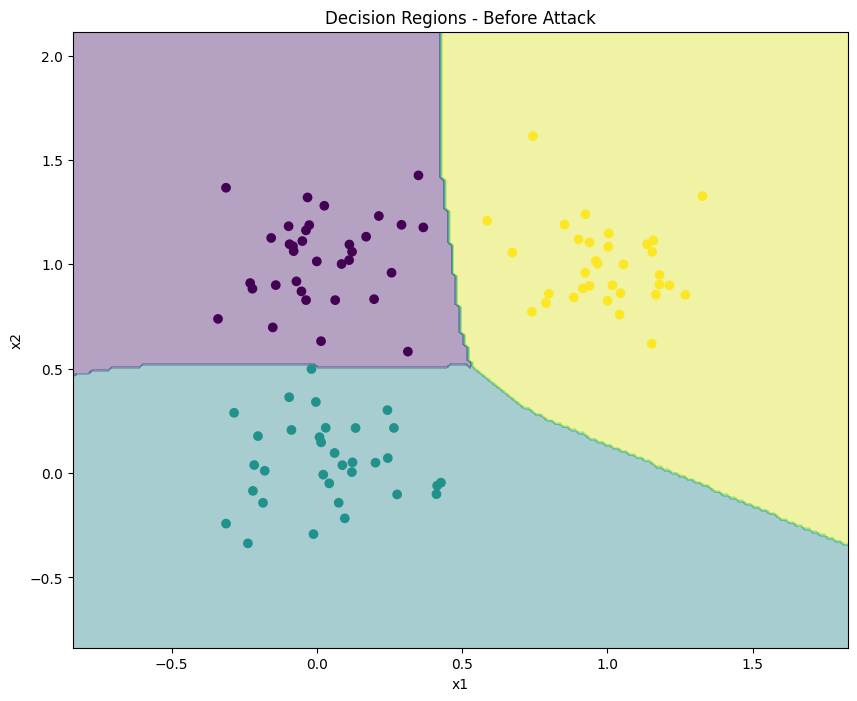

In [27]:
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.
    
    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    
    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    
    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, 
                         cmap='viridis')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 16)  # Input layer to hidden layer
        self.fc2 = torch.nn.Linear(16, 16) # Hidden layer to hidden layer
        self.fc3 = torch.nn.Linear(16, 3)  # Hidden layer to output layer
        self.relu = torch.nn.ReLU()         # ReLU activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply first layer and ReLU
        x = self.relu(self.fc2(x))  # Apply second layer and ReLU
        x = self.fc3(x)             # Apply output layer (no activation here)
        return x

X_train, y_train = make_blobs(n_samples=500, 
                  centers=[(0, 1), (0, 0), (1, 1)],
                  n_features=2,
                  cluster_std=0.2,
                  random_state=999)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test, y_test = make_blobs(n_samples=100, 
                  centers=[(0, 1), (0, 0), (1, 1)],
                  n_features=2,
                  cluster_std=0.2,
                  random_state=999)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=100)
secmlt_model = BasePytorchClassifier(model, trainer=trainer)
secmlt_model.train(tr_dataloader)

plot_decision_regions(model, X_test, y_test, title="Decision Regions - Before Attack")

In [28]:
# we execute the attack on a single sample
epsilon = 0.7
alpha = 1e-2
num_iter=500

x_advs, deltas = untargeted_l2_pgd(model, X_test[0,:], y_test[0], epsilon=epsilon, alpha=alpha, num_iter=num_iter, lb=-2,ub=2)
y_pred = model(x_advs).argmax(dim=-1)
print("Predicted label:", y_pred.item(), "\nReal label:",y_test[0].item())

Predicted label: 0 
Real label: 2


Since we also saved the deltas at each step, we can now plot its path with an helper function.

In [29]:
import numpy as np
import torch

def plot_attack_path(model, X, y, x_init, deltas, epsilon, title="Attack Path on Decision Regions"):
    """
    Plots decision regions, the initial sample as a green large circle, the attack path, and the last sample as a red cross. Optionally plots the L2 epsilon ball.

    Args:
        model: Trained PyTorch model.
        X: Input features (torch.Tensor) for decision region background.
        y: Labels (torch.Tensor) for coloring points.
        x_init: Initial sample (torch.Tensor, shape [2] or [1,2]).
        deltas: Attack deltas (torch.Tensor, shape [2, N] or [N, 2]).
        epsilon: (Optional) Radius of the L2 ball to plot.
        title: Plot title.
    """
    import matplotlib.pyplot as plt

    # Prepare mesh grid for decision regions
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', edgecolor='k', s=30, alpha=0.7)

    # Initial sample as a green large circle
    x_init_np = x_init.detach().cpu().numpy()
    if x_init_np.ndim == 2:
        x_init_np = x_init_np[0]


    # Plot L2 epsilon ball if epsilon is provided
    if epsilon is not None:
        circle = plt.Circle((x_init_np[0], x_init_np[1]), epsilon, color='red', fill=False, linestyle='--', linewidth=2, label=f'L2 Ball (ε={epsilon})')
        plt.gca().add_patch(circle)

    # Compute attack path: x_init + deltas (assume deltas shape [2, N])
    if deltas.shape[0] == 2:
        path = x_init_np.reshape(2, 1) + deltas.detach().cpu().numpy()
        path = path.T
    else:
        path = x_init_np + deltas.detach().cpu().numpy()
    plt.plot(path[:, 0], path[:, 1], color='black', linewidth=2, marker='o', markersize=4, label='Attack Path')

    # Last sample as a red cross
    last_sample = path[-1]
    plt.scatter(x_init_np[0], x_init_np[1], marker='o', color='green', s=250, edgecolor='black', linewidths=2, label='Initial Sample', zorder = 2)
    plt.scatter(last_sample[0], last_sample[1], marker='x', color='red', s=200, linewidths=4, label='Final Sample', zorder = 2)
    
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

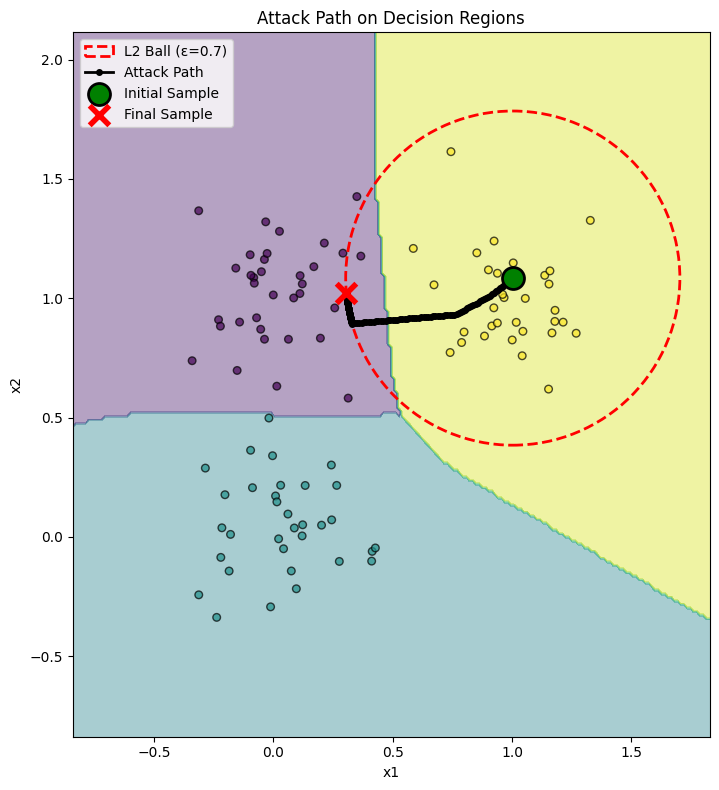

In [30]:
plot_attack_path(model, X_test, y_test, X_test[0,:], deltas, epsilon, title="Attack Path on Decision Regions")

### Exercise 1
* Try to change the parameters of the attack, and understand what they change in terms of the success of the attack.
* Create a function that produce **targeted** attacks, taking inspiration from the untargeted one.

#### Ex 1.1

Predicted label: 2 
Real label: 2


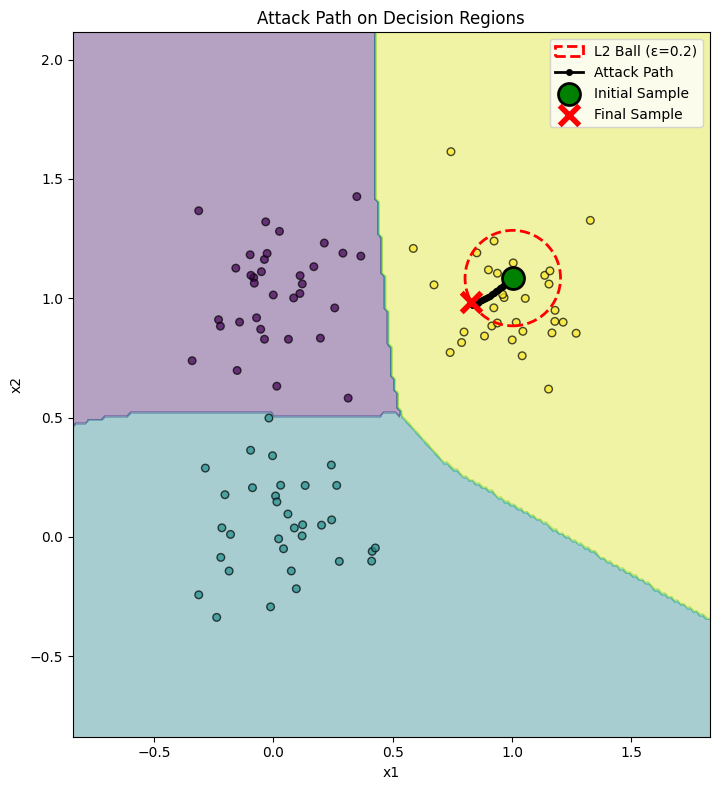

In [33]:
epsilon = 0.2
alpha = 1e-2
num_iter = 500

x_advs, deltas = untargeted_l2_pgd(model, X_test[0,:], y_test[0], epsilon=epsilon, alpha=alpha, num_iter=num_iter, lb=-2, ub=2)
y_pred = model(x_advs).argmax(dim=-1)
print("Predicted label:", y_pred.item(), "\nReal label:", y_test[0].item())

plot_attack_path(model, X_test, y_test, X_test[0,:], deltas, epsilon, title="Attack Path on Decision Regions")

#### Ex 1.2

Predicted label: 2 
Real label: 2


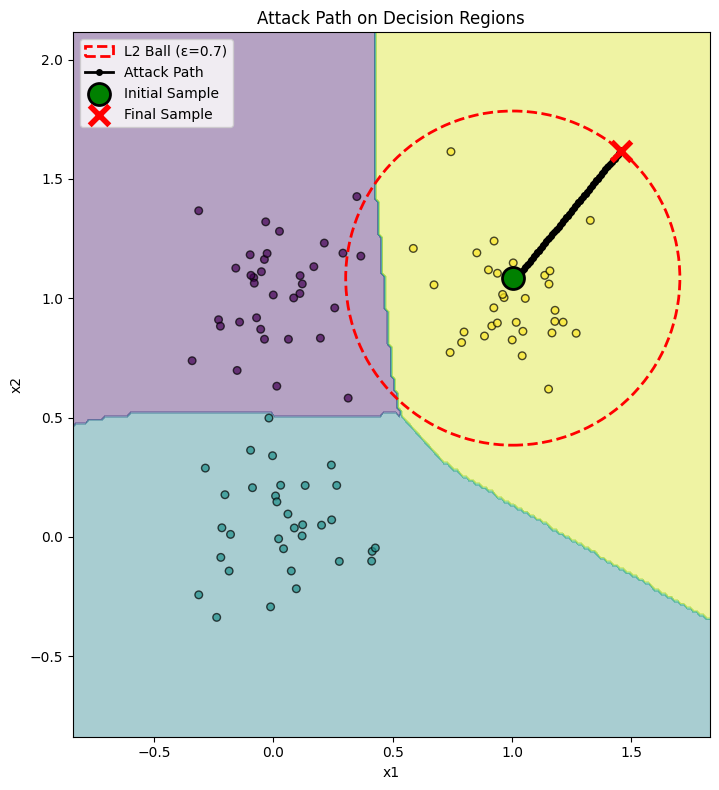

In [51]:
def targeted_l2_pgd(model, x, y_target, epsilon=0.3, alpha=0.01, num_iter=40, lb=-1, ub=1):
    model.eval()
    delta = torch.zeros_like(x, requires_grad=True)
    deltas = torch.zeros((x.shape[0], num_iter) + x.shape[1:], device=x.device)
    for _ in range(num_iter):
        outputs = model(x + delta)
        loss = torch.nn.CrossEntropyLoss()(outputs, y_target)   #distance to my target
        loss.backward()
        
        gradient = delta.grad.data / (delta.grad.data.norm() + 1e-10)
        delta.data = delta - alpha * gradient   #gradient descent to follow the direction of the local min
                                                #you can also leave the + and put the - in the loss
        
        if delta.data.norm() > epsilon:
            delta.data = epsilon * delta.data / delta.data.norm()

        delta.data = torch.clamp(delta.data, lb - x, ub - x)
        deltas[:, _] = delta.data
        delta.grad.zero_()

    return x.data + delta.data, deltas

epsilon = 0.7
alpha = 1e-2
num_iter = 500

x_advs, deltas = targeted_l2_pgd(model, X_test[0,:], y_test[0], epsilon=epsilon, alpha=alpha, num_iter=num_iter, lb=-2, ub=2)
y_pred = model(x_advs).argmax(dim=-1)
print("Predicted label:", y_pred.item(), "\nReal label:", y_test[0].item())

plot_attack_path(model, X_test, y_test, X_test[0,:], deltas, epsilon, title="Attack Path on Decision Regions")

## Attacks with SecML Torch

Since implementing a single attack is complicated and prone to error, SecML Torch already offers native or imported attacks to minimize the number of implementations.
Each attack can be instantiated in an object-oriented way as follows.

In [ ]:
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.evasion.pgd import PGD

epsilon = 0.7
alpha = 1e-2
num_iter=500
perturbation_model = LpPerturbationModels.L2

native_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_iter,
    step_size=alpha,
    random_start=False, #to start on the center of the circle. if True, you start somewhere else
    y_target=None,  #untargeted
    backend=Backends.NATIVE,    #native ver of the attacks
)

adv_dataloader = native_attack(secmlt_model, ts_dataloader)
x_adv = adv_dataloader.dataset[0][0]
y_pred = model(x_adv).argmax(dim=-1)
print("Predicted label:", y_pred.item(), "\nReal label:",y_test[0].item())


Predicted label: 0 
Real label: 2


In [53]:
single_sample_loader = DataLoader(TensorDataset(X_test[0:1,:], y_test[0:1]), batch_size=1, shuffle=False)

native_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_iter,
    step_size=alpha,
    random_start=False,
    y_target=None,
    backend=Backends.NATIVE,
)

adv_dataloader = native_attack(secmlt_model, single_sample_loader)

We can plot the attack path by creating a tracker, which is an object that, once plugged into SecML, it can accumulate information to be used later. More examples on the GitHub page of the repository.

In [54]:
from secmlt.trackers.trackers import Tracker
from secmlt.trackers.trackers import MULTI_SCALAR

class Sample2DTracker(Tracker):
    def __init__(self) -> None:
        """Create adversarial 2D sample tracker."""
        super().__init__("Sample", MULTI_SCALAR)

        self.tracked = []

    def track(
        self,
        iteration: int,
        loss: torch.Tensor,
        scores: torch.Tensor,
        x_adv: torch.Tensor,
        delta: torch.Tensor,
        grad: torch.Tensor,
    ) -> None:
        self.tracked.append(x_adv)

import numpy as np
import torch

def secmlt_plot_attack_path(model, X, y, x_init, x_advs, epsilon, title="Attack Path on Decision Regions"):
    """
    Plots decision regions, the initial sample as a green large circle, the attack path, and the last sample as a red cross. Optionally plots the L2 epsilon ball.

    Args:
        model: Trained PyTorch model.
        X: Input features (torch.Tensor) for decision region background.
        y: Labels (torch.Tensor) for coloring points.
        x_init: Initial sample (torch.Tensor, shape [2] or [1,2]).
        deltas: Attack deltas (torch.Tensor, shape [2, N] or [N, 2]).
        epsilon: (Optional) Radius of the L2 ball to plot.
        title: Plot title.
    """
    import matplotlib.pyplot as plt

    x_advs = x_advs.T.squeeze().numpy()
    # Prepare mesh grid for decision regions
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='viridis', edgecolor='k', s=30, alpha=0.7)

    # Initial sample as a green large circle
    x_init_np = x_init.detach().cpu().numpy()
    if x_init_np.ndim == 2:
        x_init_np = x_init_np[0]


    # Plot L2 epsilon ball if epsilon is provided
    if epsilon is not None:
        circle = plt.Circle((x_init_np[0], x_init_np[1]), epsilon, color='red', fill=False, linestyle='--', linewidth=2, label=f'L2 Ball (ε={epsilon})')
        plt.gca().add_patch(circle)
    
    # Concatenate the initial point to the attack path
    path = np.vstack([x_init_np, x_advs])
    plt.plot(path[:, 0], path[:, 1], color='black', linewidth=2, marker='o', markersize=4, label='Attack Path')

    # Last sample as a red cross
    last_sample = path[-1]
    plt.scatter(path[0,0], path[0,1], marker='o', color='green', s=250, edgecolor='black', linewidths=2, label='Initial Sample', zorder = 2)
    plt.scatter(last_sample[0], last_sample[1], marker='x', color='red', s=200, linewidths=4, label='Final Sample', zorder = 2)
    
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

C:\Users\ftame\AppData\Local\Temp\ipykernel_16304\2029542554.py:40: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4424.)
  x_advs = x_advs.T.squeeze().numpy()


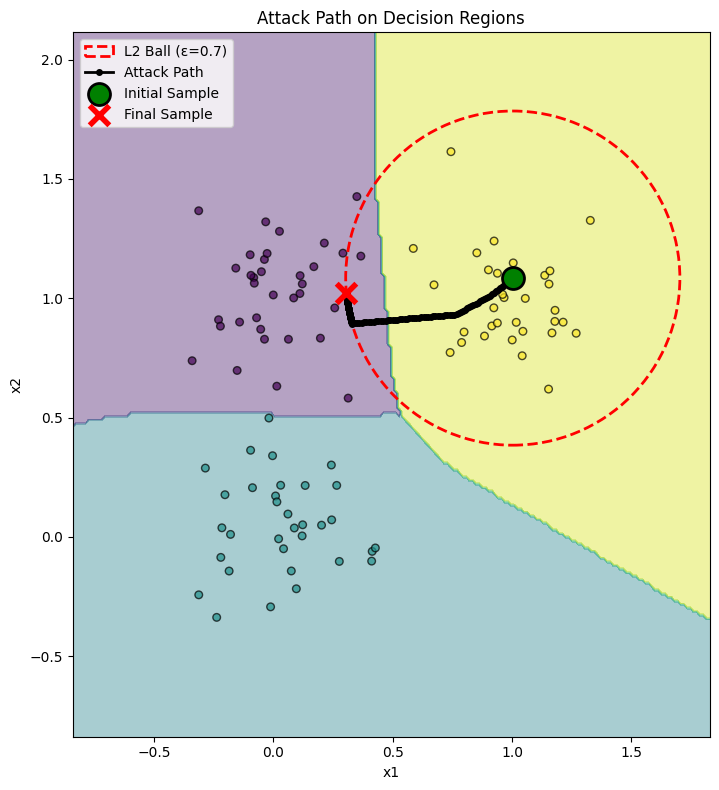

In [55]:
sample_tracker = Sample2DTracker()
native_attack = PGD(
    perturbation_model=perturbation_model,
    epsilon=epsilon,
    num_steps=num_iter,
    step_size=alpha,
    random_start=False,
    y_target=None,
    backend=Backends.NATIVE,
    trackers=[sample_tracker],
    ub=3,
    lb=-3,
)

adv_dataloader = native_attack(secmlt_model, single_sample_loader)
secmlt_plot_attack_path(secmlt_model.model, X_test, y_test, X_test[0,:], sample_tracker.get(), epsilon, title="Attack Path on Decision Regions")

### Exercise 2

* Try to change the random start parameter. What can you notice to the result of the attack?
* Try to change the epsilon value. What can you say about the performance of the attack?
* Compute the attack with SecML Torch and compute the accuracy of the attack. Is it enough to compute the robustness of a model?